In [1]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [2]:
# print(theano.config)
class Integrate(theano.Op):
    def __init__(self, expr, var, lower, upper, *inputs):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = inputs
        self.lower = lower
        self.upper = upper
        self._func = theano.function(
            [var] + list(self._extra_vars),
            self._expr,
            on_unused_input='ignore'
        )
    
    def make_node(self, *inputs):
        assert len(self._extra_vars)  == len(inputs)
        return theano.Apply(self, list(inputs), [T.dscalar().type()])
    
    def perform(self, node, inputs, out):
        x = np.linspace(self.lower, self.upper, num=3)
        y = np.array([self._func(i , *inputs) for i in x])
        val = trapz(y, x)
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        out, = grads
        grads = T.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, self.lower, self.upper, *self._extra_vars)
            darg = out * integrate(*inputs)
            dargs.append(darg)
            
        return dargs

In [3]:
def forward_fold_log_parabola_symbolic_no_units(amplitude, alpha, beta, e_true_lo, e_true_hi, selected_bin_ids, aeff, livetime, edisp, observation):
    amplitude *= 1e-11
    
    energy = T.dscalar('energy')
    amplitude_ = T.dscalar('amplitude_')
    alpha_ = T.dscalar('alpha_')
    beta_ = T.dscalar('beta_')

    func = amplitude_ * energy **(-alpha_ - beta_ * T.log10(energy))
    
    counts = []
    for a, b in zip(e_true_lo, e_true_hi):
        c = Integrate(func, energy, a, b, amplitude_, alpha_, beta_)(amplitude, alpha, beta)
        counts.append(c)

    counts = T.stack(counts)
    aeff = aeff
    

    counts *= aeff
    counts *= livetime
    edisp = edisp
    
    idx = selected_bin_ids
    return T.dot(counts, edisp)[idx[0]:idx[1]]

def forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observations, fit_range=None):
    
    amplitude *= 1e-11
    obs_bins = observations[0].on_vector.energy.bins.to_value(u.TeV)
    predicted_signal_per_observation = []
    for observation in observations:
        aeff_bins = observation.aeff.energy
        e_reco_bins = observation.edisp.e_reco
        e_true_bins = observation.edisp.e_true

        lower =  e_true_bins.lo.to_value(u.TeV)
        upper = e_true_bins.hi.to_value(u.TeV)

        energy = T.dscalar('energy')
        amplitude_ = T.dscalar('amplitude_')
        alpha_ = T.dscalar('alpha_')
        beta_ = T.dscalar('beta_')

        func = amplitude_ * energy **(-alpha_ - beta_ * T.log10(energy))

        counts = []
        for a, b in zip(lower, upper):
            c = Integrate(func, energy, a, b, amplitude_, alpha_, beta_)(amplitude, alpha, beta)
            counts.append(c)

        counts = T.stack(counts)
        aeff = observation.aeff.data.data.to_value(u.cm**2).astype(np.float32)
        aeff = aeff


        counts *= aeff
        counts *= observation.livetime.to_value(u.s)
        edisp = observation.edisp.pdf_matrix
        edisp = edisp

        predicted_signal_per_observation.append(T.dot(counts, edisp))

    predicted_counts = T.sum(predicted_signal_per_observation, axis=0)
    if fit_range is not None:
        energy_bins = observations[0].on_vector.energy.bins
        idx = np.searchsorted(energy_bins.to_value(u.TeV), fit_range.to_value(u.TeV))
        predicted_counts = predicted_counts[idx[0]:idx[1]]

    return predicted_counts


In [4]:
def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]

In [5]:
obs_list, fit_range = load_spectrum_observations('fact')
observations = obs_list
energy_bins = observations[0].on_vector.energy.bins

In [6]:
amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')

print(fit_range)

cf_fast = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observations, fit_range=fit_range)
counts_symbolic = cf_fast.eval({amplitude: 4.0, alpha: 2.0, beta: 0.5})
counts_symbolic, counts_symbolic.shape, apply_range(counts_symbolic, bins=energy_bins, fit_range=fit_range)[0].shape

[ 0.4 30. ] TeV


(array([ 14.43495112,  27.0465557 ,  47.84444151,  77.51652647,
        113.07310067, 148.02603138, 175.69778694, 192.17195833,
        196.82898106, 191.10612479, 177.20977073, 158.13731217,
        137.41158039, 117.66932917,  99.97265699,  84.15327589,
         70.03711504,  57.52210219,  46.85345721,  37.94002902,
         30.5203661 ,  24.22927814,  18.91720323,  14.50065284,
         10.90732094,   8.07117832,   5.85499537,   4.1174762 ,
          2.70923858,   1.57945823]), (30,), (20,))

In [7]:
def calc_mu_b(mu_s, on_data, off_data, exposure_ratio):
    alpha = exposure_ratio
    c = alpha * (on_data + off_data) - (alpha + 1)*mu_s
    d = pm.math.sqrt(c**2 + 4 * (alpha + 1)*alpha*off_data*mu_s)
    mu_b = (c + d) / (2*alpha*(alpha + 1))
    return mu_b

In [8]:
def get_observed_counts(observations, fit_range=None):
    on_data = []
    off_data = []
    
    for observation in observations:
        on_data.append(observation.on_vector.data.data.value)
        off_data.append(observation.off_vector.data.data.value)
    on_data = np.sum(on_data, axis=0)
    off_data = np.sum(off_data, axis=0)
    if fit_range is not None:
        energy_bins = observations[0].on_vector.energy.bins
        on_data, off_data = apply_range(on_data, off_data, fit_range=fit_range, bins=energy_bins)
    
    return on_data, off_data

In [9]:
on_data, off_data = get_observed_counts(observations, fit_range=fit_range)
# on_data, off_data = apply_range(on_data, off_data, fit_range=fit_range, bins=energy_bins)

exposure_ratio = observations[0].alpha[0]
print(on_data.shape, off_data.shape, exposure_ratio )
livetime = observations[0].livetime.to_value(u.s)

# edisp = observation.edisp.pdf_matrix
print(fit_range)
model = pm.Model(theano_config={'compute_test_value': 'ignore'})
with model:

    amplitude = pm.TruncatedNormal('amplitude', mu=4, sd=0.5, lower=0.01, testval=4)
    alpha = pm.TruncatedNormal('alpha', mu=2.5, sd=0.5, lower=0.01, testval=2.5)
    beta = pm.TruncatedNormal('beta', mu=0.5, sd=0.5, lower=0.01, testval=0.5)
    
#     amplitude = pm.HalfFlat('amplitude',testval=4)
#     alpha = pm.HalfFlat('alpha', testval=2.5)
#     beta = pm.HalfFlat('beta', testval=0.5)
    
#     mu_s = forward_fold_log_parabola_symbolic_no_units(amplitude, alpha, beta, e_true_lo, e_true_hi, idx, aeff, livetime, edisp,  observation)
    mu_s = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observations, fit_range=fit_range)
#     pm.Potential('ll', wstat_model_symbolic(mu_s, observation, fit_range=fit_range))
#     mu_b = pm.HalfFlat('mu_b', shape=len(off_data))
#     mu_b = pm.TruncatedNormal('mu_b', mu=off_data, sd=5, shape=len(off_data), lower=0)
    mu_b  = pm.Deterministic('mu_b', calc_mu_b(mu_s, on_data, off_data, exposure_ratio), )
    b = pm.Poisson('background', mu=mu_b, observed=off_data, shape=len(off_data))    
    s = pm.Poisson('signal', mu=mu_s + exposure_ratio * mu_b, observed=on_data)

(30,) (30,) 0.11111111111111117
[ 0.4 30. ] TeV


In [10]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

amplitude_lowerbound__ 1.1579998782570455
alpha_lowerbound__ 0.6864916757531656
beta_lowerbound__ -0.7605610100048488
background -89.10181511046177
signal -218.17912787232274


625it [00:03, 186.13it/s]


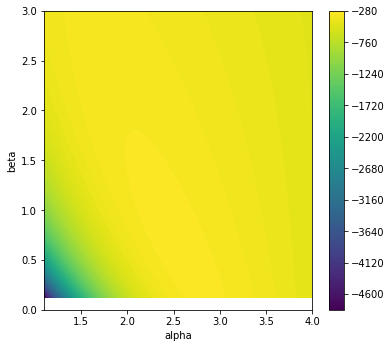

In [11]:
N = 25
betas = np.linspace(0, 3, N)
alphas = np.linspace(1.1, 4.0, N)
f = model.logp
zs = []
a, b = np.meshgrid(alphas, betas)
for al, be in tqdm(zip(a.ravel(), b.ravel())):
        
    p = f(amplitude_lowerbound__ = np.log(4), alpha_lowerbound__ = np.log(al), beta_lowerbound__= np.log(be))
#     print(p)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=124)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

In [13]:
with model:
    trace = pm.sample(600, cores=6, tune=600, init='auto') # advi+adapt_diag

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [beta, alpha, amplitude]
Sampling 6 chains: 100%|██████████| 7200/7200 [05:33<00:00,  5.72draws/s]
The acceptance probability does not match the target. It is 0.8825558214952327, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9127566229495332, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813131441217611, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
pm.traceplot(trace)